<a href="https://colab.research.google.com/github/govindaa-sharma/project1/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip uninstall transformers -y -q
!pip uninstall tokenizers -y -q
!pip uninstall tensorflow-text -y -q

!pip install keras-nlp --quiet
!pip install tensorflow-text --quiet


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import cv2
from PIL import Image
import os


import keras_nlp
import tensorflow_text as tf_text

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest

from tqdm.notebook import tqdm

print(f"TensorFlow Version: {tf.__version__}")
print(f"KerasNLP Version: {keras_nlp.__version__}")

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPU Available: {gpus[0].name}. Your model will use this GPU.")
else:
    print("WARNING: No GPU detected. The model will run on CPU, which will be EXTREMELY SLOW for deep learning.")
    print("Please try to get a GPU runtime if possible (Runtime -> Change runtime type -> GPU).")

tf.random.set_seed(42)
np.random.seed(42)

IMG_HEIGHT = 224
IMG_WIDTH = 224

TensorFlow Version: 2.19.0
KerasNLP Version: 0.18.1
GPU Available: /physical_device:GPU:0. Your model will use this GPU.


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

drive_zip_path = '/content/drive/MyDrive/fashion-product-images-small.zip'

extract_dir = 'fashion_data'
if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)

# !unzip -q -n {drive_zip_path} -d {extract_dir}

csv_path = os.path.join(extract_dir, 'styles.csv')
try:
    df = pd.read_csv(csv_path, on_bad_lines='skip', low_memory=False)
except TypeError:
    df = pd.read_csv(csv_path, error_bad_lines=False, warn_bad_lines=True, low_memory=False)

df['image_path'] = df['id'].apply(lambda x: os.path.join(extract_dir, 'images', f'{x}.jpg'))

initial_rows = len(df)
df.dropna(subset=['productDisplayName', 'masterCategory', 'image_path'], inplace=True)
df = df[df['productDisplayName'].apply(lambda x: isinstance(x, str) and len(x.strip()) > 0)]
df = df[df['masterCategory'].apply(lambda x: isinstance(x, str) and len(x.strip()) > 0)]
df['image_exists'] = df['image_path'].apply(lambda x: os.path.exists(x))
df = df[df['image_exists'] == True]
df.drop(columns=['image_exists'], inplace=True)
final_rows = len(df)

print(f"Total products loaded: {len(df)}")
print(f"Unique Master Categories: {df['masterCategory'].nunique()}")

Total products loaded: 44412
Unique Master Categories: 7


/tmp/ipython-input-2-675909015.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['image_exists'], inplace=True)


In [ ]:
category_counts = df['masterCategory'].value_counts()
MIN_SAMPLES_PER_CATEGORY = 5
categories_to_keep = category_counts[category_counts >= MIN_SAMPLES_PER_CATEGORY].index.tolist()
df_filtered = df[df['masterCategory'].isin(categories_to_keep)].copy()
df = df_filtered

print(f"New total products after filtering: {len(df)}")
print(f"New number of unique categories after filtering: {len(df['masterCategory'].unique())}")

New total products after filtering: 44411
New number of unique categories after filtering: 6


In [ ]:
def _load_and_preprocess_image_inner(image_path_bytes):

    image_path = image_path_bytes.numpy().decode('utf-8')

    try:
        img = Image.open(image_path).convert('RGB')
        img = img.resize((IMG_WIDTH, IMG_HEIGHT))
        img_array = np.array(img).astype(np.float32) / 255.0
        return img_array
    except Exception as e:
        return np.zeros((IMG_HEIGHT, IMG_WIDTH, 3), dtype=tf.float32)

def load_and_preprocess_image(image_path_tensor):
    image_tensor = tf.py_function(
        _load_and_preprocess_image_inner,
        [image_path_tensor],
        [tf.float32]
    )[0]
    image_tensor.set_shape([IMG_HEIGHT, IMG_WIDTH, 3])
    return image_tensor

In [ ]:
MAX_TEXT_LEN = 64

preprocessor = keras_nlp.models.BertPreprocessor.from_preset(
    "bert_base_en",
    sequence_length=MAX_TEXT_LEN
)

def get_preprocessed_text_inputs(texts):
    texts_tensor = tf.constant(texts.tolist())
    preprocessed_output_dict = preprocessor(texts_tensor)

    token_ids_np = preprocessed_output_dict['token_ids'].numpy()
    segment_ids_np = preprocessed_output_dict['segment_ids'].numpy()
    padding_mask_np = preprocessed_output_dict['padding_mask'].numpy()

    return token_ids_np, segment_ids_np, padding_mask_np


X_token_ids, X_segment_ids, X_padding_mask = get_preprocessed_text_inputs(df['productDisplayName'])

print(f"Shape of KerasNLP Token IDs (NumPy): {X_token_ids.shape}")
print(f"Shape of KerasNLP Segment IDs (NumPy): {X_segment_ids.shape}")
print(f"Shape of KerasNLP Padding Mask (NumPy): {X_padding_mask.shape}")

Shape of KerasNLP Token IDs (NumPy): (44411, 64)
Shape of KerasNLP Segment IDs (NumPy): (44411, 64)
Shape of KerasNLP Padding Mask (NumPy): (44411, 64)


In [ ]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df['masterCategory'])

num_classes = len(label_encoder.classes_)
y_one_hot = keras.utils.to_categorical(y_encoded, num_classes=num_classes)

print(f"Shape of one-hot encoded labels (NumPy): {y_one_hot.shape}")

Shape of one-hot encoded labels (NumPy): (44411, 6)


/tmp/ipython-input-7-4289305692.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y='masterCategory', order=df['masterCategory'].value_counts().index, palette='viridis')


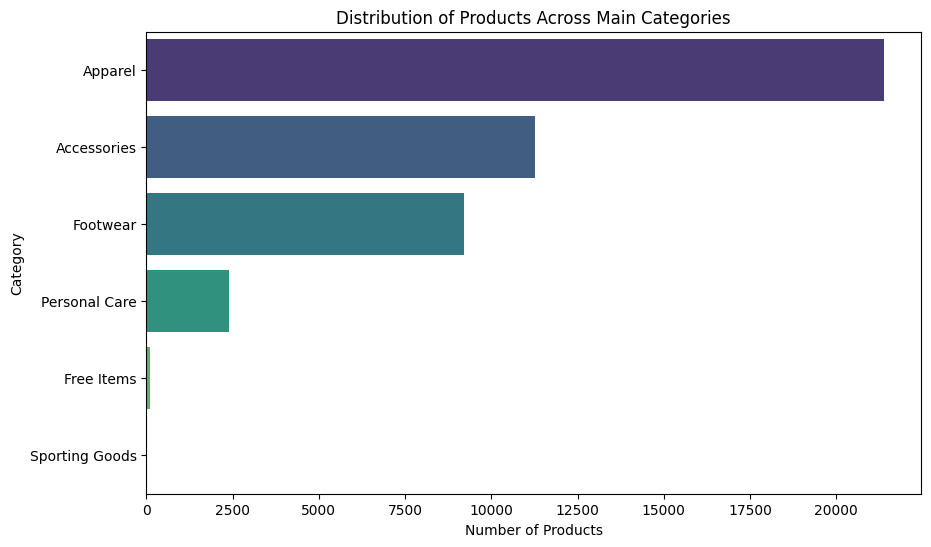

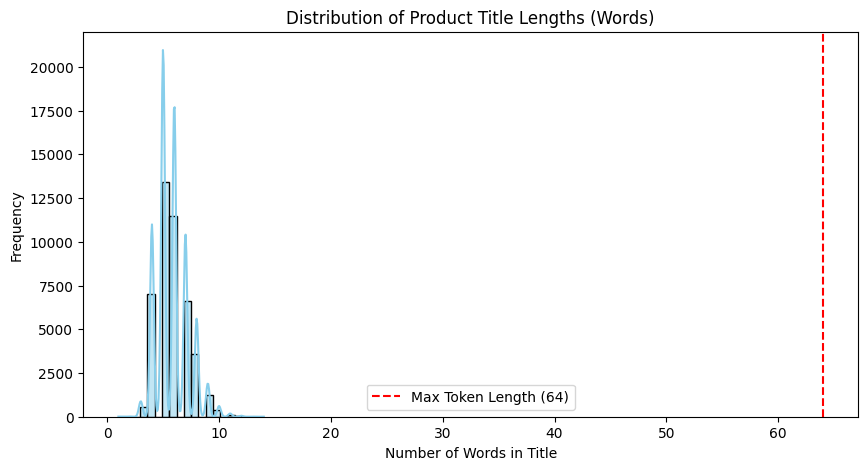

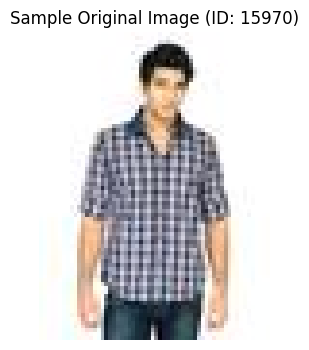

Original Sample Title: 'Turtle Check Men Navy Blue Shirt'
KerasNLP Token IDs (first 20): [  101 26024 23114  3401  2506  2770 14104  3740   102     0     0     0
     0     0     0     0     0     0     0     0]
KerasNLP Segment IDs (first 20): [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
KerasNLP Padding Mask (first 20): [ True  True  True  True  True  True  True  True  True False False False
 False False False False False False False False]
Number of products for Training: 31087
Number of products for Validation: 6662
Number of products for Testing: 6662


In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, y='masterCategory', order=df['masterCategory'].value_counts().index, palette='viridis')
plt.title('Distribution of Products Across Main Categories')
plt.xlabel('Number of Products')
plt.ylabel('Category')
plt.show()

df['title_length'] = df['productDisplayName'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 5))
sns.histplot(df['title_length'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of Product Title Lengths (Words)')
plt.xlabel('Number of Words in Title')
plt.ylabel('Frequency')
plt.axvline(MAX_TEXT_LEN, color='red', linestyle='--', label=f'Max Token Length ({MAX_TEXT_LEN})')
plt.legend()
plt.show()

sample_idx = 0
sample_original_img = Image.open(df['image_path'].iloc[sample_idx])
plt.figure(figsize=(4, 4))
plt.imshow(sample_original_img)
plt.title(f"Sample Original Image (ID: {df['id'].iloc[sample_idx]})")
plt.axis('off')
plt.show()

sample_title = df['productDisplayName'].iloc[sample_idx]
sample_preprocessed_output_dict = preprocessor(tf.constant([sample_title]))

sample_token_ids_display = sample_preprocessed_output_dict['token_ids']
sample_segment_ids_display = sample_preprocessed_output_dict['segment_ids']
sample_padding_mask_display = sample_preprocessed_output_dict['padding_mask']

print(f"Original Sample Title: '{sample_title}'")
print(f"KerasNLP Token IDs (first 20): {sample_token_ids_display[0, :20].numpy()}")
print(f"KerasNLP Segment IDs (first 20): {sample_segment_ids_display[0, :20].numpy()}")
print(f"KerasNLP Padding Mask (first 20): {sample_padding_mask_display[0, :20].numpy()}")


X_img_paths_train, X_img_paths_temp, \
X_token_ids_train, X_token_ids_temp, \
X_segment_ids_train, X_segment_ids_temp, \
X_padding_mask_train, X_padding_mask_temp, \
y_train, y_temp = train_test_split(
    df['image_path'].values,
    X_token_ids,
    X_segment_ids,
    X_padding_mask,
    y_one_hot,
    test_size=0.3,
    random_state=42,
    stratify=y_one_hot
)

X_img_paths_val, X_img_paths_test, \
X_token_ids_val, X_token_ids_test, \
X_segment_ids_val, X_segment_ids_test, \
X_padding_mask_val, X_padding_mask_test, \
y_val, y_test = train_test_split(
    X_img_paths_temp,
    X_token_ids_temp,
    X_segment_ids_temp,
    X_padding_mask_temp,
    y_temp,
    test_size=0.5,
    random_state=42,
    stratify=y_temp
)

print(f"Number of products for Training: {len(X_img_paths_train)}")
print(f"Number of products for Validation: {len(X_img_paths_val)}")
print(f"Number of products for Testing: {len(X_img_paths_test)}")

In [ ]:
GLOBAL_BATCH_SIZE = 64
def prepare_sample_kerasnlp(image_path_tensor, token_ids_tensor, segment_ids_tensor, padding_mask_tensor, label_tensor): # <-- NEW: padding_mask_tensor
    image = load_and_preprocess_image(image_path_tensor)

    return {
        'image_input': image,
        'token_ids': token_ids_tensor,
        'segment_ids': segment_ids_tensor,
        'padding_mask': padding_mask_tensor
    }, label_tensor


train_dataset = tf.data.Dataset.from_tensor_slices((
    X_img_paths_train,
    X_token_ids_train,
    X_segment_ids_train,
    X_padding_mask_train,
    y_train
))
train_dataset = train_dataset.map(prepare_sample_kerasnlp, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=1024)
train_dataset = train_dataset.batch(GLOBAL_BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((
    X_img_paths_val,
    X_token_ids_val,
    X_segment_ids_val,
    X_padding_mask_val,
    y_val
))
val_dataset = val_dataset.map(prepare_sample_kerasnlp, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(GLOBAL_BATCH_SIZE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

print("Training and Validation Data Pipelines created successfully!")

Training and Validation Data Pipelines created successfully!


In [ ]:
image_input = keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3), name='image_input')
base_cnn = keras.applications.MobileNetV2(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    include_top=False,
    weights='imagenet'
)
base_cnn.trainable = False
x_img = base_cnn(image_input)
x_img = layers.GlobalAveragePooling2D(name='image_global_avg_pooling')(x_img)


token_ids = keras.Input(shape=(MAX_TEXT_LEN,), dtype=tf.int32, name='token_ids')
segment_ids = keras.Input(shape=(MAX_TEXT_LEN,), dtype=tf.int32, name='segment_ids')
padding_mask = keras.Input(shape=(MAX_TEXT_LEN,), dtype=tf.bool, name='padding_mask')

bert_backbone = keras_nlp.models.BertBackbone.from_preset("bert_base_en")
bert_backbone.trainable = False


bert_inputs_dict = {
    'token_ids': token_ids,
    'segment_ids': segment_ids,
    'padding_mask': padding_mask
}

bert_outputs_dict = bert_backbone(bert_inputs_dict)

x_text = bert_outputs_dict['pooled_output']



concatenated_features = layers.concatenate([x_img, x_text], name='concatenate_features')
x = layers.Dense(256, activation='relu', name='dense_1')(concatenated_features)
x = layers.Dropout(0.3, name='dropout_1')(x)
x = layers.Dense(128, activation='relu', name='dense_2')(x)
x = layers.Dropout(0.3, name='dropout_2')(x)
output = layers.Dense(num_classes, activation='softmax', name='output_layer')(x)


model = keras.Model(
    inputs=[image_input, token_ids, segment_ids, padding_mask],
    outputs=output,
    name='Product_Classifier_Model'
)


model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "Product_Classifier_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mobilenetv2_1.00_2… │ (None, 7, 7,      │  2,257,984 │ image_input[0][0] │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ padding_mask        │ (None, 64)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ segment_ids         │ (None, 64)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_ids           │ (None, 64)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image_global_avg_p… │ (None, 1280)      │          0 │ mobilenetv2_1.00… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bert_backbone       │ [(None, 768),     │ 108,310,2… │ padding_mask[0][… │
│ (BertBackbone)      │ (None, 64, 768)]  │            │ segment_ids[0][0… │
│                     │                   │            │ token_ids[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_featur… │ (None, 2048)      │          0 │ image_global_avg… │
│ (Concatenate)       │                   │            │ bert_backbone[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │    524,544 │ concatenate_feat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │     32,896 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_layer        │ (None, 6)         │        774 │ dropout_2[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 111,126,470 (423.91 MB)

 Trainable params: 558,214 (2.13 MB)

 Non-trainable params: 110,568,256 (421.78 MB)

In [ ]:
# Step 5: Model Training

EPOCHS = 10

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    verbose=1
)

model.save('trained_product_classifier_model.keras')

Epoch 1/10
486/486 ━━━━━━━━━━━━━━━━━━━━ 382s 682ms/step - accuracy: 0.9050 - loss: 0.2974 - val_accuracy: 0.9848 - val_loss: 0.0696
Epoch 2/10
486/486 ━━━━━━━━━━━━━━━━━━━━ 310s 631ms/step - accuracy: 0.9765 - loss: 0.0917 - val_accuracy: 0.9869 - val_loss: 0.0574
Epoch 3/10
486/486 ━━━━━━━━━━━━━━━━━━━━ 316s 620ms/step - accuracy: 0.9815 - loss: 0.0726 - val_accuracy: 0.9865 - val_loss: 0.0588
Epoch 4/10
486/486 ━━━━━━━━━━━━━━━━━━━━ 327s 631ms/step - accuracy: 0.9848 - loss: 0.0629 - val_accuracy: 0.9877 - val_loss: 0.0578
Epoch 5/10
486/486 ━━━━━━━━━━━━━━━━━━━━ 308s 628ms/step - accuracy: 0.9857 - loss: 0.0538 - val_accuracy: 0.9889 - val_loss: 0.0514
Epoch 6/10
486/486 ━━━━━━━━━━━━━━━━━━━━ 265s 541ms/step - accuracy: 0.9874 - loss: 0.0495 - val_accuracy: 0.9853 - val_loss: 0.0629
Epoch 7/10
486/486 ━━━━━━━━━━━━━━━━━━━━ 365s 629ms/step - accuracy: 0.9881 - loss: 0.0468 - val_accuracy: 0.9851 - val_loss: 0.0645
Epoch 8/10
486/486 ━━━━━━━━━━━━━━━━━━━━ 322s 628ms/step - accuracy: 0.9867 -

In [11]:
print("\n--- Evaluating Model on Test Set ---")

def prepare_sample_for_test(image_path_tensor, token_ids_tensor, segment_ids_tensor, padding_mask_tensor, label_tensor):
    image = load_and_preprocess_image(image_path_tensor)
    return {
        'image_input': image,
        'token_ids': token_ids_tensor,
        'segment_ids': segment_ids_tensor,
        'padding_mask': padding_mask_tensor
    }, label_tensor

test_dataset = tf.data.Dataset.from_tensor_slices((
    X_img_paths_test,
    X_token_ids_test,
    X_segment_ids_test,
    X_padding_mask_test,
    y_test
))
test_dataset = test_dataset.map(prepare_sample_for_test, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(GLOBAL_BATCH_SIZE)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)


test_loss, test_accuracy = model.evaluate(test_dataset, verbose=1)

print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

if test_accuracy >= 0.98:
    print("\nCongratulations! Your model shows excellent generalization on unseen data!")
else:
    print("\nModel performance on test set is good, but might have room for improvement.")


--- Evaluating Model on Test Set ---
105/105 ━━━━━━━━━━━━━━━━━━━━ 45s 424ms/step - accuracy: 0.9855 - loss: 0.0631

Test Loss: 0.0672
Test Accuracy: 0.9856

Congratulations! Your model shows excellent generalization on unseen data!



--- Visualizing Training History ---


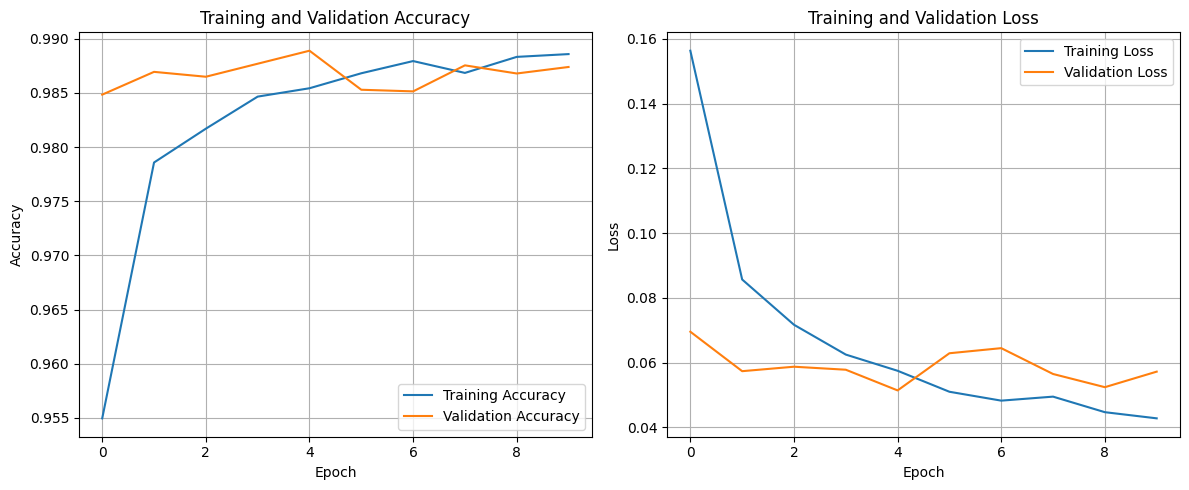

Training history plots generated. These plots help assess learning progress and overfitting.


In [12]:
print("\n--- Visualizing Training History ---")

hist_df = pd.DataFrame(history.history)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(hist_df['accuracy'], label='Training Accuracy')
plt.plot(hist_df['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(hist_df['loss'], label='Training Loss')
plt.plot(hist_df['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print("Training history plots generated. These plots help assess learning progress and overfitting.")

In [14]:
print("\n--- Extracting Fused Features for Anomaly Detection ---")

feature_extractor = keras.Model(
    inputs=model.inputs,
    outputs=model.get_layer('concatenate_features').output,
    name='Feature_Extractor_Model'
)

train_features_dataset = train_dataset.map(lambda x_dict, y: x_dict)
test_features_dataset = test_dataset.map(lambda x_dict, y: x_dict)


print("Extracting features from training data (this might take a few minutes)...")

train_fused_features = feature_extractor.predict(train_features_dataset, verbose=1)
print(f"Shape of extracted training features: {train_fused_features.shape}")

print("Extracting features from test data (this might take a few minutes)...")

test_fused_features = feature_extractor.predict(test_features_dataset, verbose=1)
print(f"Shape of extracted test features: {test_fused_features.shape}")

print("Fused features (combined image and text understanding) extracted successfully.")


--- Extracting Fused Features for Anomaly Detection ---
Extracting features from training data (this might take a few minutes)...
486/486 ━━━━━━━━━━━━━━━━━━━━ 233s 457ms/step
Shape of extracted training features: (31087, 2048)
Extracting features from test data (this might take a few minutes)...
105/105 ━━━━━━━━━━━━━━━━━━━━ 49s 467ms/step
Shape of extracted test features: (6662, 2048)
Fused features (combined image and text understanding) extracted successfully.


In [ ]:
print("\n--- Training Anomaly Detector (Isolation Forest) ---")

scaler = StandardScaler()
train_fused_features_scaled = scaler.fit_transform(train_fused_features)
test_fused_features_scaled = scaler.transform(test_fused_features)

iso_forest = IsolationForest(contamination=0.01, random_state=42)

iso_forest.fit(train_fused_features_scaled)

print("Isolation Forest trained successfully on training features.")

anomaly_scores = iso_forest.decision_function(test_fused_features_scaled)

anomaly_predictions = iso_forest.predict(test_fused_features_scaled)

print("\nAnomaly scores and predictions generated for test data.")

anomaly_indices = np.where(anomaly_predictions == -1)[0]
num_anomalies = len(anomaly_indices)

print(f"\nTotal products in test set: {len(test_fused_features)}")
print(f"Number of predicted anomalies in test set (based on contamination={iso_forest.contamination}): {num_anomalies}")

if num_anomalies > 0:
    print("\n--- Sample of Detected Anomalies (Details Below) ---")

    original_df_anomaly_indices = test_original_indices[anomaly_indices]
    anomalous_products_info = df.loc[original_df_anomaly_indices].copy()

    anomalous_products_info['anomaly_score'] = anomaly_scores[anomaly_indices]

    anomalous_products_info.sort_values(by='anomaly_score', ascending=True, inplace=True)

    print(f"\nDetails for the top {min(10, num_anomalies)} most anomalous products (sorted by score):")
    for i, row in anomalous_products_info.head(min(10, num_anomalies)).iterrows():
        print(f"\n--- Anomaly {anomalous_products_info.index.get_loc(i) + 1} (Original ID: {row['id']}) ---")
        print(f"  Title: {row['productDisplayName']}")
        print(f"  Category: {row['masterCategory']}")
        print(f"  Anomaly Score: {row['anomaly_score']:.4f} (Lower is more anomalous)")

        try:
            img = Image.open(row['image_path'])
            plt.figure(figsize=(3, 3))
            plt.imshow(img)
            plt.title(f"Anomaly: {row['productDisplayName'][:30]}...")
            plt.axis('off')
            plt.show()
        except Exception as e:
            print(f"  Could not display image for ID {row['id']}: {e}")

else:
    print("No anomalies detected based on the chosen contamination factor. Try adjusting 'contamination' in IsolationForest.")

print("\nAnomaly detection phase complete!")